In [1]:

# import data manipulation + plotting 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# import model dependencies
import cx_analysis

# import model library + model diagnostics
import os
import sys
sys.path.append(os.getcwd()[:-10]+'impact_attribution')
import ols_assumptions_check
import model_comparison

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

The notebook analysis customer survey data for UK for data mostly in the year 2022. The data available is for Xarelto and for Womens Health Care (WHC).
There are two parts:
1) Understanding connection between customer satisfaction questions (CSAT) and Net Promoter Score (NPS)
2) Using NPS as a feature in the current Impact Attribution Model

The NPS question is as follows:
- How likely are you to recommend [Field-Touchpoint_Name] from Bayer to a colleague?

The three CSAT questions are as follows:
- The content was clear and understandable
- The information was useful for my work with patients
- The educational content was suitable for my professional development

The full Xarelto data set includes 366 data points, which we can use for a regression model using CSAT questions as features and the NPS score as the target. 

Overall HCPs are very satisfied as all three driver questions score on average between 4.6 and 4.8. The three drivers are all statistically significant and the ranking is as follows:
1) The educational content was suitable for my professional development (coefficient=.82, pvalue=.00)
2) The content was clear and understandable (coefficient=.38, pvalue=.00)
2) The information was useful for my work with patients (coefficient=.24, pvalue=.03)

Model performance was around .4 for r2 applying cross-validation.

For WHC the model performance was weak (r2 around 0 on test set). Only one feature showed a low pvalue, but because the test performance has been so bad, there is little trust in the coefficients.

In [37]:
# load pre-processed data:

df_wh = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/cx_data_uk/df_wh.csv')
df_webinar = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/cx_data_uk/df_webinar.csv')
df_csat_xrlt_all = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/cx_data_uk/df_csat_xrlt_all.csv')

In [38]:
# Instantiate analysis class:

cx = cx_analysis.CXAnalysis()

# Instantiate impact model + model diagnosics:
cl = ols_assumptions_check.ols_check(grouping="cstmr_1_id", time_window="yyyymm")
mc = model_comparison.ModelComparison()

### Xarelto - Driver Analysis Webinar

CSAT questions:
- The content was clear and understandable
- The information was useful for my work with patients
- The content was suitable for my professional development

In [41]:
df_webinar.isna().sum() / df_webinar.shape[0]

Unnamed: 0               0.000000
StartDate                0.000000
EndDate                  0.000000
Status                   0.000000
IPAddress                0.004785
Progress                 0.000000
Duration (in seconds)    0.000000
Finished                 0.000000
RecordedDate             0.000000
ResponseId               0.000000
RecipientLastName        1.000000
RecipientFirstName       1.000000
RecipientEmail           1.000000
ExternalReference        1.000000
LocationLatitude         0.114833
LocationLongitude        0.114833
DistributionChannel      0.000000
UserLanguage             0.000000
Q1.1_NPS_GROUP           0.000000
Q1.1                     0.000000
Q2                       0.971292
Q3                       0.803828
Q4                       0.330144
Q5                       0.971292
Q7_11                    0.114833
Q7_12                    0.114833
Q7_13                    0.114833
Q7_1                     0.186603
Q7_2                     0.181818
Q7_4          

In [42]:
df_webinar.shape


(209, 53)

In [43]:
# select columns and remove NAs:

cols = ['Q1.1',
        'Q7_11','Q7_12','Q7_13', #CSAT block
        'Q7_1','Q7_2' #additional questions
       ]

df_webinar_clean = df_webinar[cols].dropna()

for col in cols:
    df_webinar_clean[col] = df_webinar_clean[col].astype(int)

In [44]:
# shuffle df and run OLS with cross-validation:

df_webinar_clean = df_webinar_clean.sample(frac=1)

betas, pvalues, test_prediction, test_truth, r2_train, r2_test, residuals, fitted, dfz=cx.cross_validation_split(df=df_webinar_clean,
                                                                                                                    features=cols[1:],
                                                                                                                    target='Q1.1',
                                                                                                                    split=5)


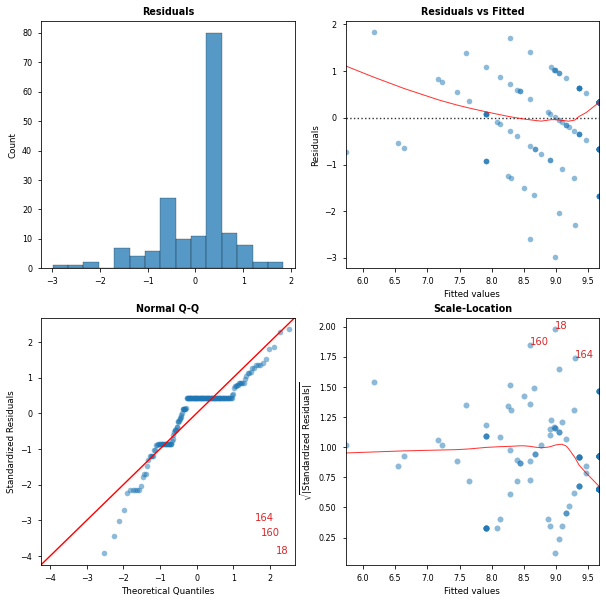

,vif
Q7_1,1.531400
Q1.1,2.024043
Q7_2,2.219083
Q7_11,2.288855
Q7_12,2.340327
Q7_13,2.794685
const,148.791043


In [45]:
# Model diagnostics:

cl = ols_assumptions_check.ols_check(grouping="cstmr_1_id", time_window="yyyymm")

cl.show_all_classic_diagnostic_plots(df_webinar_clean,
                                     residuals,
                                     fitted,
                                     cols[1:])

display(cl.vif_test(df_webinar_clean))

In [46]:
# Analyse Train-Test performance:

r2_train, r2_test

(0.5117361667829912, 0.449190429904089)

In [47]:
# Have a look at fitted coefficients:

dfz

,features,beta,lower_bound_beta,upper_bound_beta,pvalue
4,Q7_2,0.475420,0.064699,0.886142,0.023560
2,Q7_13,0.383229,0.019232,0.747226,0.039187
1,Q7_12,0.375316,0.083843,0.666789,0.011932
3,Q7_1,0.312947,0.121057,0.504836,0.001545
0,Q7_11,0.203259,-0.183728,0.590247,0.301218


In [48]:
# create final overview:

z = {'features': [
                  'Q7_2',
                  'Q7_13','Q7_12','Q7_1','Q7_11' #CSAT block ranking
                   
                   ],
     'sentiment': [
                   'The speakers were credible and authentic',
                   'The educational content was suitable for my professional development',
                   'The information was useful for my work with patients',
                   'The webinar allowed for interaction and exchange',
                   'The content was clear and understandable']
    }
dft = pd.DataFrame(z)

# add mean value per question to identify potential for increase:

dfy = pd.DataFrame(df_webinar_clean[cols[1:]].mean()).rename(columns={0:'mean_values'})

dfx = round(dft.merge(dfz, on='features').merge(dfy, left_on='features', right_index=True),2)

dfx

,features,sentiment,beta,lower_bound_beta,upper_bound_beta,pvalue,mean_values
0,Q7_2,The speakers were credible and authentic,0.48,0.06,0.89,0.02,4.83
1,Q7_13,The educational content was suitable for my professional development,0.38,0.02,0.75,0.04,4.72
2,Q7_12,The information was useful for my work with patients,0.38,0.08,0.67,0.01,4.69
3,Q7_1,The webinar allowed for interaction and exchange,0.31,0.12,0.50,0.00,4.54
4,Q7_11,The content was clear and understandable,0.20,-0.18,0.59,0.30,4.79


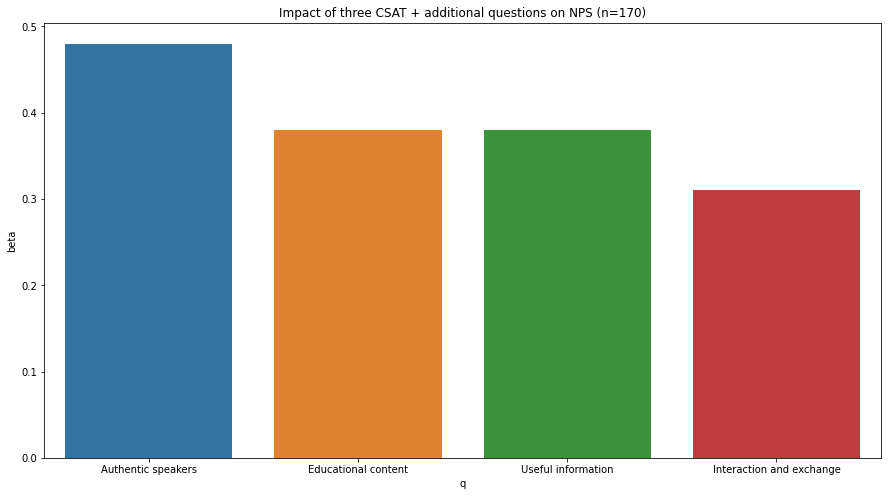

In [49]:
dfx['q'] = ['Authentic speakers', 'Educational content', 'Useful information', 'Interaction and exchange', 'Clear content']

plt.figure(figsize=(15,8))
sns.barplot(data=dfx.iloc[0:4], x="q", y="beta")
plt.title('Impact of three CSAT + additional questions on NPS (n=170)')
plt.show()

### CSAT: all Xarelto 

In [51]:
df_webinar.rename(columns={'Q7_11':'Q2.1_1', # clear content
                           'Q7_12':'Q2.1_5', # usefull information
                           'Q7_13':'Q2.1_6', # educational content
                           }, 
                           inplace=True)

In [53]:
df_csat_xrlt_all = df_webinar[['Q2.1_1','Q2.1_5','Q2.1_6','Q1.1']]

In [54]:
df_csat_xrlt_all.isna().sum()/df_csat_xrlt_all.shape[0]

Q2.1_1    0.114833
Q2.1_5    0.114833
Q2.1_6    0.114833
Q1.1      0.000000
dtype: float64

In [55]:
cols = ['Q1.1', 'Q2.1_1','Q2.1_5','Q2.1_6']

df_csat_xrlt_all_clean = df_csat_xrlt_all[cols].dropna()

for col in cols:
    df_csat_xrlt_all_clean[col] = df_csat_xrlt_all_clean[col].astype(int)

In [56]:
display(df_csat_xrlt_all_clean.shape)

(185, 4)

In [57]:
# shuffle df and run OLS with cross-validation:

df_csat_xrlt_all_clean = df_csat_xrlt_all_clean.sample(frac=1)

betas, pvalues, test_prediction, test_truth, r2_train, r2_test, residuals, fitted, dfz=cx.cross_validation_split(df=df_csat_xrlt_all_clean,
                                                                                                                    features=cols[1:],
                                                                                                                    target='Q1.1',
                                                                                                                    split=10)

In [58]:
dfz

,features,beta,lower_bound_beta,upper_bound_beta,pvalue
2,Q2.1_6,0.710852,0.370367,1.051337,0.000058
0,Q2.1_1,0.462054,0.101924,0.822185,0.012205
1,Q2.1_5,0.398173,0.109998,0.686347,0.007034


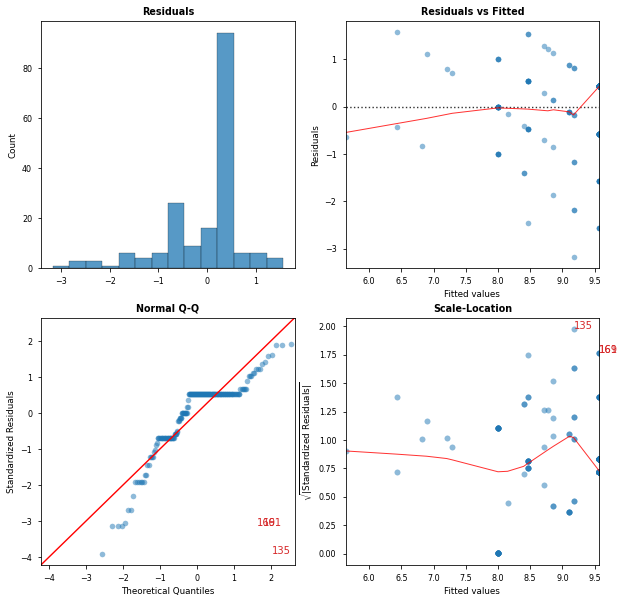

,vif
Q2.1_1,1.918558
Q2.1_5,2.066138
Q2.1_6,2.258173
const,116.817487


In [59]:
# Model diagnostics:

cl = ols_assumptions_check.ols_check(grouping="cstmr_1_id", time_window="yyyymm")

cl.show_all_classic_diagnostic_plots(df_csat_xrlt_all_clean,
                                     residuals,
                                     fitted,
                                     cols[1:])

display(cl.vif_test(df_csat_xrlt_all_clean[cols[1:]]))

In [60]:
# Analyse Train-Test performance:

r2_train, r2_test

(0.44586323414427353, 0.4060896212900079)

In [61]:
# create final overview:

z = {'features': ['Q2.1_6','Q2.1_1','Q2.1_5'],
     'sentiment': ['Educational content was suitable for my professional development',
                   'The content was clear and understandable',
                   'The information was useful for my work with patients'
                  ]
    }
dft = pd.DataFrame(z)

# add mean value per question to identify potential for increase:

dfy = pd.DataFrame(df_csat_xrlt_all_clean[cols[1:]].mean()).rename(columns={0:'mean_values'})

dfx = round(dft.merge(dfz, on='features').merge(dfy, left_on='features', right_index=True),2)

dfx

,features,sentiment,beta,lower_bound_beta,upper_bound_beta,pvalue,mean_values
0,Q2.1_6,Educational content was suitable for my professional development,0.71,0.37,1.05,0.00,4.71
1,Q2.1_1,The content was clear and understandable,0.46,0.10,0.82,0.01,4.78
2,Q2.1_5,The information was useful for my work with patients,0.40,0.11,0.69,0.01,4.68


In [62]:
dfx['q'] = ['Educational content','Clear content','Useful information']
dfx

,features,sentiment,beta,lower_bound_beta,upper_bound_beta,pvalue,mean_values,q
0,Q2.1_6,Educational content was suitable for my professional development,0.71,0.37,1.05,0.00,4.71,Educational content
1,Q2.1_1,The content was clear and understandable,0.46,0.10,0.82,0.01,4.78,Clear content
2,Q2.1_5,The information was useful for my work with patients,0.40,0.11,0.69,0.01,4.68,Useful information


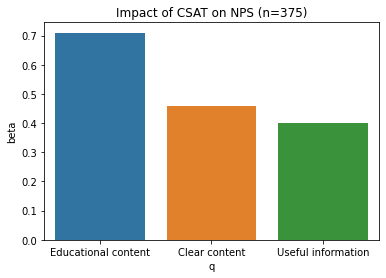

In [63]:

dfx['relative_beta'] = (dfx.beta/sum(dfx.beta)).values

sns.barplot(data=dfx, x="q", y="beta")
plt.title('Impact of CSAT on NPS (n=375)')
plt.show()

### Driver Analysis WH

In [ ]:
# general satisfaction CSAT:

# Bayer as a company - Q6_1
# product and medical communication - Q6_3
# bayer symposia and events - Q6_4

In [ ]:
#  value driver CSAT:

# content i received mattered
# information was useful for my work
# content was suitable
# communication in preferred channels
# opportunities for interaction and discussion

In [64]:
df_wh.isna().sum() / df_wh.shape[0]

Unnamed: 0                                                                        0.000000
StartDate                                                                         0.000000
EndDate                                                                           0.000000
Status                                                                            0.000000
IPAddress                                                                         0.007519
Progress                                                                          0.000000
Duration (in seconds)                                                             0.000000
Finished                                                                          0.000000
RecordedDate                                                                      0.000000
ResponseId                                                                        0.000000
RecipientLastName                                                                 1.000000

In [66]:
cols = ['Q1.1',
        #
        'Q6_1',
        #'Q6_3',
        'Q6_4',
        'Q7_1',
        'Q7_2',
        'Q7_3',
        'Q8_5'
       ]
competitive_cols = ['Q11_1','Q11_2','Q11_3']

csat_general = ['Q1.1', 'Q6_1', 'Q6_3', 'Q6_4']

In [67]:
df_wh_clean = df_wh[csat_general].dropna()

for col in csat_general:
    df_wh_clean[col] = df_wh_clean[col].astype(int)

In [68]:
# shuffle df and run OLS with cross-validation:
cols_to_use = csat_general

print(df_wh_clean.shape)
df_wh_clean = df_wh_clean.sample(frac=1)

betas, pvalues, test_prediction, test_truth, r2_train, r2_test, residuals, fitted, dfz=cx.cross_validation_split(df=df_wh_clean,
                                                                                                                features=cols_to_use[1:],
                                                                                                                target='Q1.1',
                                                                                                                split=4)

(84, 4)


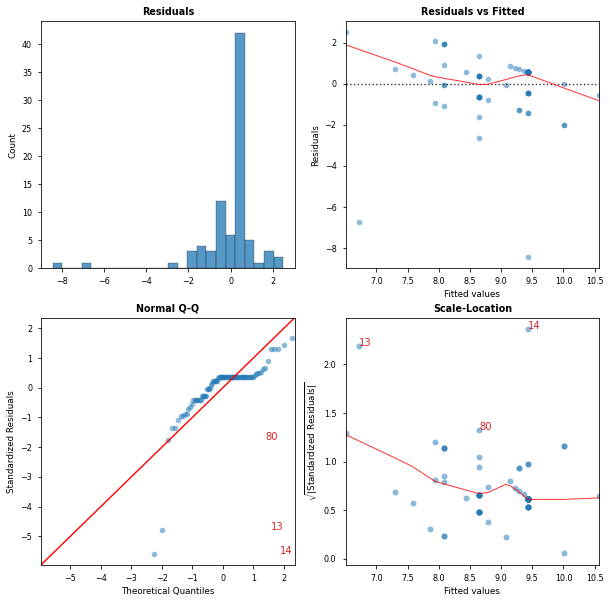

,vif
Q6_4,1.732542
Q6_1,2.691202
Q6_3,3.603016
const,59.673236


In [69]:
# Model diagnostics:

cl = ols_assumptions_check.ols_check(grouping="cstmr_1_id", time_window="yyyymm")

cl.show_all_classic_diagnostic_plots(df_wh_clean,
                                     residuals,
                                     fitted,
                                     cols_to_use[1:])

display(cl.vif_test(df_wh_clean[cols_to_use[1:]]))

In [70]:
# Analyse Train-Test performance:

r2_train, r2_test

(0.20197196852109178, 0.04011888071719849)

In [71]:
dfz

,features,beta,lower_bound_beta,upper_bound_beta,pvalue
1,Q6_3,1.212091,0.262321,2.161860,0.013031
0,Q6_1,0.144494,-0.617227,0.906214,0.706799
2,Q6_4,-0.568999,-1.213947,0.075950,0.082965


In [72]:
# create final overview using general CSAT features:

z = {'features': ['Q6_3','Q6_1','Q6_4'],
     'sentiment': ['Bayer as a company in general.',
                   'Our product and medical communication.',
                   'Bayer symposia and events'
                  ]
    }
dft = pd.DataFrame(z)

# add mean value per question to identify potential for increase:

dfy = pd.DataFrame(df_wh_clean[cols_to_use[1:]].mean()).rename(columns={0:'mean_values'})

dfx = round(dft.merge(dfz, on='features').merge(dfy, left_on='features', right_index=True),2)

dfx

,features,sentiment,beta,lower_bound_beta,upper_bound_beta,pvalue,mean_values
0,Q6_3,Bayer as a company in general.,1.21,0.26,2.16,0.01,4.51
1,Q6_1,Our product and medical communication.,0.14,-0.62,0.91,0.71,4.48
2,Q6_4,Bayer symposia and events,-0.57,-1.21,0.08,0.08,4.57


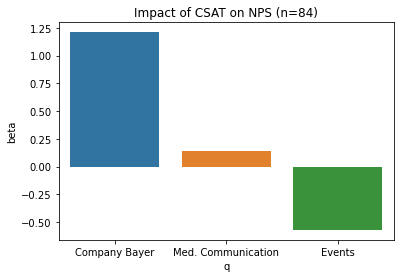

In [73]:
dfx['q'] = ['Company Bayer','Med. Communication','Events']

sns.barplot(data=dfx, x="q", y="beta")
plt.title('Impact of CSAT on NPS (n=84)')
plt.show()

### Train Sales model

In [75]:
df_uk = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/uk_cx_sales_mdb.csv')

/home/jan_rathfelder/Development/scale-up-codebase/env_4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3229: DtypeWarning: Columns (2873) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
# concat and merge: 
df_all_xrlt = pd.concat([df_webinar, # 'Q1_NPS_GROUP','Q1'
                        ])
display(df_all_xrlt['AccountID'].nunique())

18

In [78]:
df_uk[df_uk.yyyymm>='2021-10-01']['Q1.1'].isna().sum()/df_uk[df_uk.yyyymm>='2021-10-01'].shape[0]

0.989471593166468

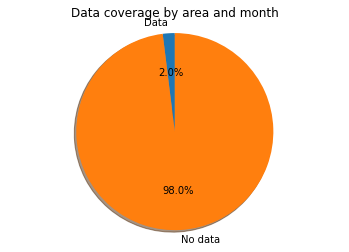

In [79]:
labels = 'Data', 'No data'
sizes = [2, 100]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data coverage by area and month')
plt.show()

In [80]:
df_uk = df_uk.fillna(0)
df_gr = df_uk[df_uk.yyyymm>='2021-10-01'].groupby('cstmr_1_id')['Q1.1'].mean().reset_index()
df_gr['flag'] = np.where(df_gr['Q1.1']==0,0,1)

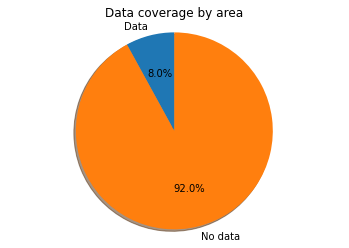

In [81]:
labels = 'Data', 'No data'
sizes = [np.sum(df_gr['flag']==1), np.sum(df_gr['flag']==0)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data coverage by area')
plt.show()


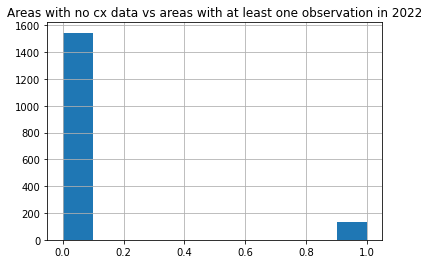

In [82]:
df_gr['flag'].hist()
plt.title('Areas with no cx data vs areas with at least one observation in 2022')
plt.show()

In [84]:
# load sales + cx data file:

df_uk = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/uk_cx_sales_mdb.csv')
df_uk['Q1.1'] = df_uk['Q1.1'].fillna(0)

In [85]:
df_uk['year_month'] = df_uk[['year','month']].apply(lambda x: x[0]+x[1], axis=1)

In [86]:
bb = df_uk['year_month'].drop_duplicates()
a = pd.get_dummies(bb, drop_first=True)


In [87]:
df_uk = pd.concat((
             df_uk,
             pd.get_dummies(df_uk['year_month'], drop_first=True)), axis=1)

In [90]:
target = "sales_unit_detrended_deseasonalized_stl"

time_features = [
    "sales_unit_detrended_deseasonalized_stl_shift1",
    'sales_unit_detrended_deseasonalized_stl_shift2',
    #'sales_unit_detrended_deseasonalized_stl_shift3',
    #'sales_unit_detrended_deseasonalized_stl_shift4',
    #'sales_unit_detrended_deseasonalized_stl_shift5',
    #'sales_unit_detrended_deseasonalized_stl_shift6',
]

features = [
    "total_calls_cph_trans_3mean",
    "total_calls_non_cph_trans_3mean",
    "ae_nl_open_cph_trans_3mean",
    "ae_nl_open_non_cph_trans_3mean",
    "evnt_attend_cph_trans_3mean",
    "evnt_attend_non_cph_trans_3mean",
    "Q1.1"
]
#+a.columns.tolist()

dates_to_loop_eyl = [
    ["2021-05-01", "2022-03-01"],
    ["2021-05-01", "2022-04-01"],
    ["2021-05-01", "2022-05-01"],
    ["2021-05-01", "2022-06-01"],
]

dates_to_loop_xrlt = [
    ["2020-05-01", "2022-03-01"],
    ["2020-05-01", "2022-04-01"],
    ["2020-05-01", "2022-05-01"],
    ["2020-05-01", "2022-06-01"],
]

(38594, 13)
2020-05-01 2022-03-01
(40272, 13)
2020-05-01 2022-04-01
(41950, 13)
2020-05-01 2022-05-01
(43628, 13)
2020-05-01 2022-06-01


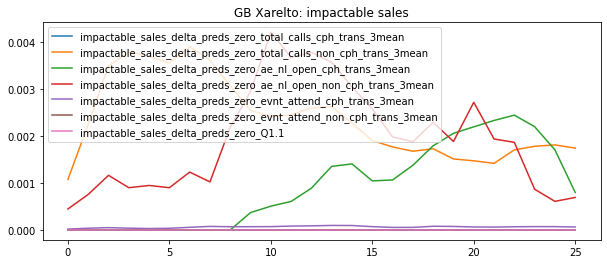

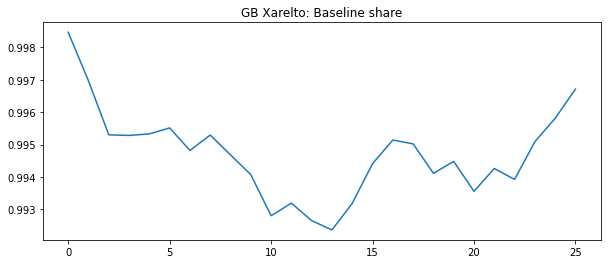

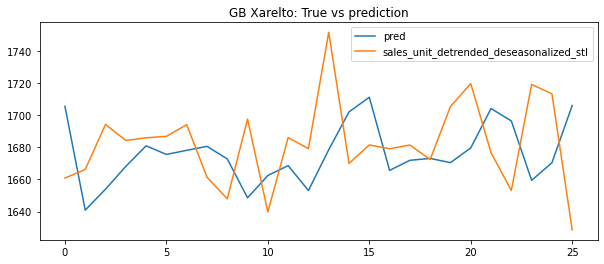

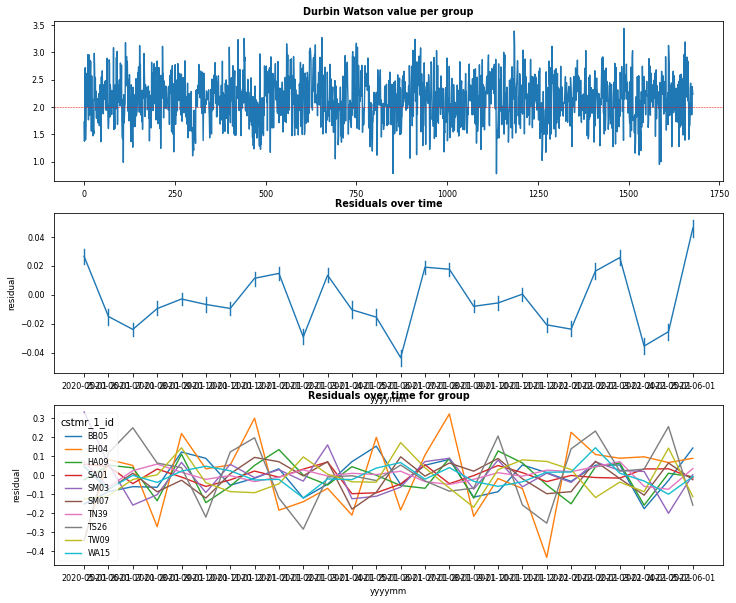

Durbin Watson for pooled sample:1.9351383631069312


,Features,2022-03-01,2022-04-01,2022-05-01,2022-06-01
0,total_calls_cph_trans_3mean_beta,0,0,0.576079,0
1,total_calls_non_cph_trans_3mean_beta,2.13476,2.16371,1.9592,2.36246
2,ae_nl_open_cph_trans_3mean_beta,0.44322,1.11718,1.11173,1.18254
3,ae_nl_open_non_cph_trans_3mean_beta,1.71681,1.45063,1.2983,1.74608
4,evnt_attend_cph_trans_3mean_beta,0.662797,0.521726,0.681551,1.53492
5,evnt_attend_non_cph_trans_3mean_beta,0.391572,0.61436,0.927296,0
6,Q1.1_beta,0,0,0,0
7,sales_unit_detrended_deseasonalized_stl_shift1_beta,0.385532,0.385655,0.39297,0.39414
8,sales_unit_detrended_deseasonalized_stl_shift2_beta,0.604855,0.605682,0.599324,0.595564
9,total_calls_cph_trans_3mean_pvalue,None,None,None,None


In [93]:
dfz2 = mc.run_mode_training(
    df=df_uk,
    target=target,
    time_features=time_features,
    features=features,
    country="GB",
    brand="Xarelto",
    area="cstmr_1_id",
    hcp_scaler="total_hcp_cnt",
    country_column="country_cd",
    brand_column="brand_nm",
    date_column="yyyymm",
    dates_to_loop=dates_to_loop_xrlt,
    selected_algo="ols_positive",
    trend_variable="trend_season_stl",
    show_classic_model_diagnostics=0,
    show_additional_model_diagnostics=1,
    show_summary_plots=1,
    show_vif=0,
    constant=0,
    area_dummy=0,
)
display(dfz2)